# RL Learning on Traffic Env

Episode 0: Reward = 7.604501595764467
Episode 1: Reward = 1.1723507253282572
Episode 2: Reward = 2.5558973381670267
Episode 3: Reward = 6.39612475454733
Episode 4: Reward = 9.114142342629963
Episode 5: Reward = 2.6232184960549327
Episode 6: Reward = 0.8463750721751957
Episode 7: Reward = 2.9703614043227855
Episode 8: Reward = 0.74029349337517
Episode 9: Reward = 0.6753300855168355
Episode 10: Reward = 8.354537075408786
Episode 11: Reward = 12.794309197975519
Episode 12: Reward = 4.515138980484598
Episode 13: Reward = 7.410883357063783
Episode 14: Reward = 1.9356836407999631
Episode 15: Reward = 3.4289802520903523
Episode 16: Reward = 12.776428680067689
Episode 17: Reward = 17.736500222392024
Episode 18: Reward = 0.2713462119135056
Episode 19: Reward = 5.776326707129479
Episode 20: Reward = 4.5457756726541145
Episode 21: Reward = 14.060755419330764
Episode 22: Reward = 7.507400704450416
Episode 23: Reward = 5.2071349770516235
Episode 24: Reward = 1.9567786882920277
Episode 25: Reward = 

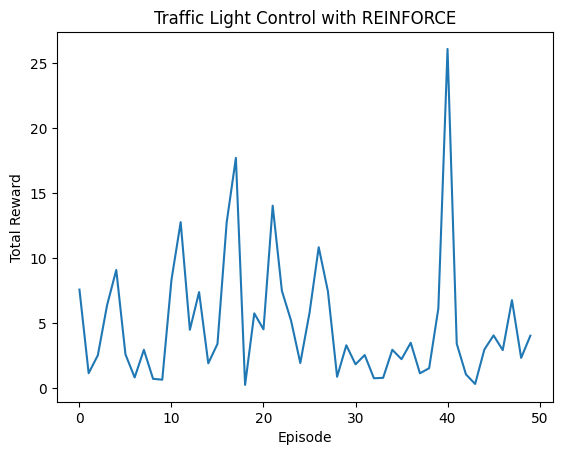

In [1]:
#q4
import gym
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt

class TrafficEnv(gym.Env):
    def __init__(self):
        super().__init__()
        self.action_space = gym.spaces.Discrete(2)
        self.observation_space = gym.spaces.Box(low=0, high=1, shape=(4,), dtype=np.float32)

    def reset(self):
        self.state = np.random.random(4)
        return self.state

    def step(self, action):
        self.state = np.random.random(4)
        reward = np.random.random()
        done = np.random.choice([True, False], p=[0.1, 0.9])
        return self.state, reward, done, {}

class PolicyNetwork(nn.Module):
    def __init__(self, input_size, output_size):
        super().__init__()
        self.fc1 = nn.Linear(input_size, 16)
        self.fc2 = nn.Linear(16, 16)
        self.fc3 = nn.Linear(16, output_size)

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.softmax(self.fc3(x), dim=1)
        return x

env = TrafficEnv()
policy = PolicyNetwork(env.observation_space.shape[0], env.action_space.n)
optimizer = optim.Adam(policy.parameters(), lr=0.01)

def select_action(state):
    state_tensor = torch.from_numpy(state).float().unsqueeze(0)
    probs = policy(state_tensor)
    distribution = torch.distributions.Categorical(probs)
    action = distribution.sample()
    return action.item(), distribution.log_prob(action)

def reinforce(episodes, gamma=0.99):
    rewards_history = []
    for episode in range(episodes):
        state = env.reset()
        log_probs = []
        rewards = []
        done = False
        
        while not done:
            action, log_prob = select_action(state)
            next_state, reward, done, _ = env.step(action)
            log_probs.append(log_prob)
            rewards.append(reward)
            state = next_state
        
        returns = []
        R = 0
        for r in reversed(rewards):
            R = r + gamma * R
            returns.insert(0, R)
        
        returns_tensor = torch.tensor(returns)
        policy_loss = []
        for log_prob, R in zip(log_probs, returns_tensor):
            policy_loss.append(-log_prob * R)
        
        optimizer.zero_grad()
        loss = torch.stack(policy_loss).sum()
        loss.backward()
        optimizer.step()
        
        rewards_history.append(sum(rewards))
        print(f"Episode {episode}: Reward = {sum(rewards)}")
    
    return rewards_history

rewards = reinforce(50)

plt.plot(rewards)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("Traffic Light Control with REINFORCE")
plt.show()